## W.  Wrangling The Pronto Cycle Share datasets

### W. 1 Reading in the datasets

The Pronto Seattle cycle share data is available in 3 separate CSV files.
1. Station.csv contains data about the 58 Pronto cycle docks around Seattle - https://www.kaggle.com/pronto/cycle-share-dataset/data
2. Trip.csv contains data about every trip taken using the Pronto Cycle share system in Seattle from 2014 to 2016 - https://www.kaggle.com/pronto/cycle-share-dataset/data
3. Weather.csv contains data about the weather in Seattle that corresponds to the dates of the recorded trips in Seattle in the Trip.csv file - https://www.kaggle.com/pronto/cycle-share-dataset/data

Each of the 3 CSV files have been read into separate pandas dataframes. 

The CSV files are freely available to anyone who wants to use them on Kaggle Datasets - https://www.kaggle.com/datasets

In [2]:
import pandas as pd

#Importing and reading csv files directly into pandas dataframe

station_data = pd.read_csv('/Users/sam/Data Science/Datasets/station.csv')

trip_data = pd.read_csv('/Users/sam/Data Science/Datasets/trip.csv', error_bad_lines=False)

weather_data = pd.read_csv('/Users/sam/Data Science/Datasets/weather.csv')

b'Skipping line 50794: expected 12 fields, saw 20\n'


**Note: The trip.csv file contained a corrupted line which had to be skipped for the data to be successfully read into pandas DataFrame**

### W.2 Cleaning the Station Data Set 


In [3]:
#Information about the various colums in the station_data DataFrame
station_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 9 columns):
station_id           58 non-null object
name                 58 non-null object
lat                  58 non-null float64
long                 58 non-null float64
install_date         58 non-null object
install_dockcount    58 non-null int64
modification_date    17 non-null object
current_dockcount    58 non-null int64
decommission_date    4 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 4.2+ KB


 - **The station dataset contains a column for modification_date of a station which contains the date on which the station dock was modified to hold more or less cycles and null values if the station was never modified after it was initially set up. I will drop this column entirely as it contains only 17 non_null values and does not provide us with information that would be useful for our analysis.**


- **The dataset also contains an install_dockcount column which contains the cycle holding capacity of the dock at a station when it was initially set up and the current_dockcount column holds the current cycle holding capacity of a dock at a station. The current_dockcount and the install_dockcount values for a station are the same if it was never modified. Since we are only interested in current values for all stations, I will drop the install_dockcount column entirely.**


- **4 out of the 58 stations in Seattle have been decommsioned and are no longer active. I will drop these decommisioned stations from the dataset , to work with only the active stations which also makes the decommissoned_date column unecessary for our analysis and I will be able to drop it as well.**

In [4]:
#Dropping the modification_date and install_dockcount columns from the dataset
station_data = station_data.drop(['modification_date','install_dockcount'],axis=1)

In [5]:
#Extracting only those stations that were not decommisoned during the time this data was collected
active_stations = station_data['decommission_date'].isnull()
station_data = station_data.loc[active_stations]

In [6]:
#Dropping the decommision_date column from the station_data DataFrame 
station_data = station_data.drop(['decommission_date'],axis=1)

In [7]:
#Information about the columns in the cleaned station_data Dataframe
station_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 57
Data columns (total 6 columns):
station_id           54 non-null object
name                 54 non-null object
lat                  54 non-null float64
long                 54 non-null float64
install_date         54 non-null object
current_dockcount    54 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.0+ KB


#### Exploring the Cleaned station_data Dataframe

In [8]:
#The first five rows of the cleaned Dataframe
station_data.head(5)

,station_id,name,lat,long,install_date,current_dockcount
0,BT-01,3rd Ave & Broad St,47.618418,-122.350964,10/13/2014,18
1,BT-03,2nd Ave & Vine St,47.615829,-122.348564,10/13/2014,16
2,BT-04,6th Ave & Blanchard St,47.616094,-122.341102,10/13/2014,16
3,BT-05,2nd Ave & Blanchard St,47.613110,-122.344208,10/13/2014,14
4,CBD-03,7th Ave & Union St,47.610731,-122.332447,10/13/2014,20


### W.2 Cleaning the Trip Dataset

The trip dataset contains some null values only in 2 columns, namely 'gender' and 'birthyear'. Furthermore these null values only occur when the trip belongs to Short Term Passholder , which ranges from a 24 hour pass or a 3 day pass as offered by Pronto as compared to a trip made by someone who is a Member, which could be a monthly subscription or a yearly one to the Pronto Cycle Share.

For the purpose of cleaning the null values and for a more precise analysis, I will split the trip data set on the basis of the client being a Member or a Temporary Pass Holder into 2 separate datasets. 

In [9]:
#Information about the various columns in the trip_data Dataframe
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
trip_id              286857 non-null int64
starttime            286857 non-null object
stoptime             286857 non-null object
bikeid               286857 non-null object
tripduration         286857 non-null float64
from_station_name    286857 non-null object
to_station_name      286857 non-null object
from_station_id      286857 non-null object
to_station_id        286857 non-null object
usertype             286857 non-null object
gender               181557 non-null object
birthyear            181553 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 26.3+ MB


**The trip dataset contains 181,557 trips where the user was a member and 105,300 trips where the user was a Short Term Pass Holder.**

In [10]:
#Counting the number of member and short_term pass holder trips in the dataset
trip_data['usertype'].value_counts()

Member                    181557
Short-Term Pass Holder    105300
Name: usertype, dtype: int64

**To create the member only dataset, I will:**

- **Extract all the rows from the original trip dataset where the column usertype contains the value 'Member'and store it in separate dataset.**


- **Drop any rows with null value in gender or birthyear column if any remain.**


- **Drop the usertype column entirely as it has become redundant for this dataset.**

In [11]:
#Extracting information about only the member trips and storing them in a separate Dataframe
member_only = trip_data['usertype'] == 'Member'
member_trip_data = trip_data.loc[member_only]

#Dropping the 4 rows with missing values in the birthyear column from the member trip data set
birthyear_present = member_trip_data['birthyear'].notnull()
member_trip_data = member_trip_data.loc[birthyear_present]

In [12]:
#Removing the usertype column from the member trip data set since it is redundant 
member_trip_data = member_trip_data.drop(['usertype'],axis = 1)

**The new dataset 'member_trip_data' does not contain any null values in any of it's columns.**

In [13]:
member_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181553 entries, 0 to 286848
Data columns (total 11 columns):
trip_id              181553 non-null int64
starttime            181553 non-null object
stoptime             181553 non-null object
bikeid               181553 non-null object
tripduration         181553 non-null float64
from_station_name    181553 non-null object
to_station_name      181553 non-null object
from_station_id      181553 non-null object
to_station_id        181553 non-null object
gender               181553 non-null object
birthyear            181553 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 16.6+ MB


In [14]:
member_trip_data.head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,gender,birthyear
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Female,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Female,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Male,1971.0


** Since the dataset does not contain gender and birthyear data for the trips taken by non members and so these columns only contain null values. To get a clean dataset for Temporary Pass Holders, I will:**

- **Extract all the rows from the original trip dataset where the usertype column contains the value 'Temporary Pass Holder'**


- **Drop birthname and gender column completely as they only contain null values for non members** 


- **Drop the usertype column as it has become redundant for this dataset**

In [15]:
#Extracting the information about the Short Term Pass Holder trips and storing them in a separate Dataframe 
pholder_only = trip_data['usertype'] == 'Short-Term Pass Holder'
pholder_trip_data = trip_data.loc[pholder_only]

In [16]:
#Dropping the colums containing all null values in the pass holder and the usertype column which has become redundant 
pholder_trip_data = pholder_trip_data.drop(['usertype','gender','birthyear'],axis = 1)

**The new datset 'pholder_trip_data' does not contain any null values in any of it's columns**

In [17]:
pholder_trip_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105300 entries, 69 to 286856
Data columns (total 9 columns):
trip_id              105300 non-null int64
starttime            105300 non-null object
stoptime             105300 non-null object
bikeid               105300 non-null object
tripduration         105300 non-null float64
from_station_name    105300 non-null object
to_station_name      105300 non-null object
from_station_id      105300 non-null object
to_station_id        105300 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 8.0+ MB


In [18]:
pholder_trip_data.head(5)

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id
69,507,10/13/2014 12:11,10/13/2014 12:16,SEA00321,332.457,City Hall / 4th Ave & James St,City Hall / 4th Ave & James St,CBD-07,CBD-07
78,518,10/13/2014 12:20,10/13/2014 12:31,SEA00321,690.793,City Hall / 4th Ave & James St,2nd Ave & Blanchard St,CBD-07,BT-05
89,530,10/13/2014 12:43,10/13/2014 12:48,SEA00311,278.849,King Street Station Plaza / 2nd Ave Extension ...,King Street Station Plaza / 2nd Ave Extension ...,PS-05,PS-05
91,533,10/13/2014 12:48,10/13/2014 12:51,SEA00269,179.939,NE 42nd St & University Way NE,12th Ave & NE Campus Pkwy,UD-02,UD-04
92,534,10/13/2014 12:48,10/13/2014 12:58,SEA00355,590.698,9th Ave N & Mercer St,Dexter Ave & Denny Way,DPD-01,SLU-18


## E. Exploratory Analysis & Story Telling

### E.1 Counting the number of trips made by male members and female members from the members_trip_data Dataframe

In [19]:
#Counting the number of distinct values in the gender column of the member_trip_data Dataframe
member_trip_data['gender'].value_counts()

Male      140564
Female     37558
Other       3431
Name: gender, dtype: int64

Q: What is the proportion of trips made by each gender among the members of the Pronto Cycle Share , which would** also tell us how the gender demographics of the users for the cycle share system are split.
 <br>A: Men make up the majority of users at 77.42% of the total bike trips among members, women make up 20.69% of the bike trips and other genders make the remaining 1.89% of the bike trips among members

### E.2 Distribution of Trip Duration by User Type (Member or Passholder) in hours

By Plotting the distribution of the trip duration of members and passholders on separate histograms, we can better understand the concentration of values and the amount of variance in the duration of the trips made by members and temporary passholders and the differences between them.

The trip duration in the original dataframe is in seconds which I will convert to hours for easier interpretation and the data for both members and temporary pass holders contains huge outliers which I will remove for an unbiased distribution

In this segment, outliers are defined as the values that are over 3 standard deviations away from the mean.

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Summary statistics for trip duration(hours) of members

In [162]:
#Converting to hours and viewing summary statistics 
member_duration = member_trip_data['tripduration'] / 120
member_duration.describe()

count    181553.000000
mean          4.959540
std           6.233928
min           0.500067
25%           2.703292
50%           3.993017
75%           5.811417
max         233.215700
Name: tripduration, dtype: float64

In [163]:
#Filtering out outliers from the data based on the summary statistics
no_outliers = member_duration <= 30
member_duration_smooth = member_duration.loc[no_outliers]

#### Summary statistics for trip duration(hours) of temporary pass holders

In [164]:
#Converting to hours and viewing summray statistics
pholder_duration = pholder_trip_data['tripduration'] / 120
pholder_duration.describe()

count    105300.000000
mean         18.198015
std          24.661247
min           0.500925
25%           6.260269
50%          10.352696
75%          17.872894
max         239.953317
Name: tripduration, dtype: float64

In [165]:
#Filtering out outliers from the data based on the summary statistics
outliers_remove = pholder_duration <= 90
pholder_duration_smooth = pholder_duration.loc[outliers_remove]

#### Histograms showing the distribution of trip duration(Hours) for members & temporary pass holders

After removing outliers and converting to hours, the continuous distribution of trip duation has been plotted on two separate histograms for memebers(blue) and temporary pass holders(red) which makes it  easier to compare the distributions between these groups.

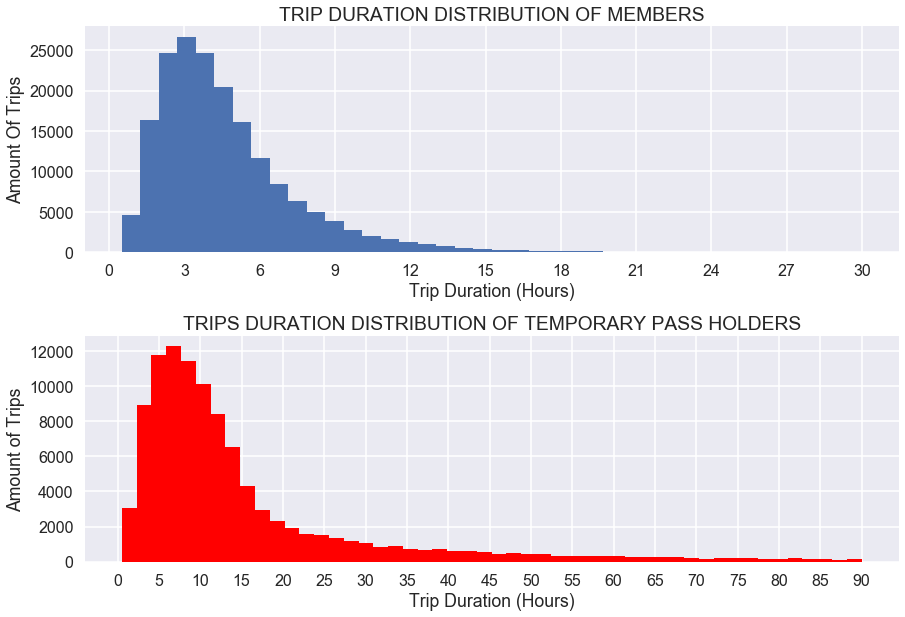

In [249]:
#Plotting the distribution of trip duration for members on plot 1
plt.style.use('seaborn-darkgrid')
plt.subplot(2,1,1)
member_duration_smooth.plot(kind='hist',bins=40)
plt.xticks([0,3,6,9,12,15,18,21,24,27,30])
plt.xlabel('Trip Duration (Hours)')
plt.ylabel('Amount Of Trips')
plt.title('TRIP DURATION DISTRIBUTION OF MEMBERS')

#Plotting the distribution of trip duration for temporary pass holders on plot 2
plt.subplot(2,1,2)
pholder_duration_smooth.plot(kind='hist',bins=50,color='red')
plt.xticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90])
plt.xlabel('Trip Duration (Hours)')
plt.ylabel('Amount of Trips')
plt.title('TRIPS DURATION DISTRIBUTION OF TEMPORARY PASS HOLDERS')

plt.tight_layout()
plt.show()

The histograms show that a higher frequency of trip duration for members is concentrated between **3-4 hours** whereas for temporary pass holders the concentration is between **6-11 hours** . 

Even after removing the outliers from both the sets of data, the histogram for temporary pass holders indicates much greater variance than the histogram for members.

The standard deviation for temporary pass holders is **24.6 hours**, which is  approximately **4 times** greater than the standard deviation for members at **6.2 hours**.

Could this lower consistency among values for temporary pass holders indicate a lack of routine as compared to members?

We can ivestigate the popular Pronto bike stations in Seattle among members and passholders and if there are huge differences between them to try to understand more about the trends and nature of the users of the temporary passes and the memberships.

### E.3 Counting Trips Made To & From All stations in Seattle classified by User Type

Counting the number of trips made to and from each station by members and temporary pass holders allows us to compare the popularity of each station among both the groups.

This also allows us to look at the stations that are more popular for one usertype as compared to the other one to further determine the nature of the users of temporary passes and memberships which could be useful for effectively segmenting Pronto's customer base.

#### Horizontal Bar Graph showing the comparison between the amount of trips made by Pass Holders and Members FROM each station

This graph highlights the difference in popularity of each station between temporary pass holders and members as a starting point for trips.

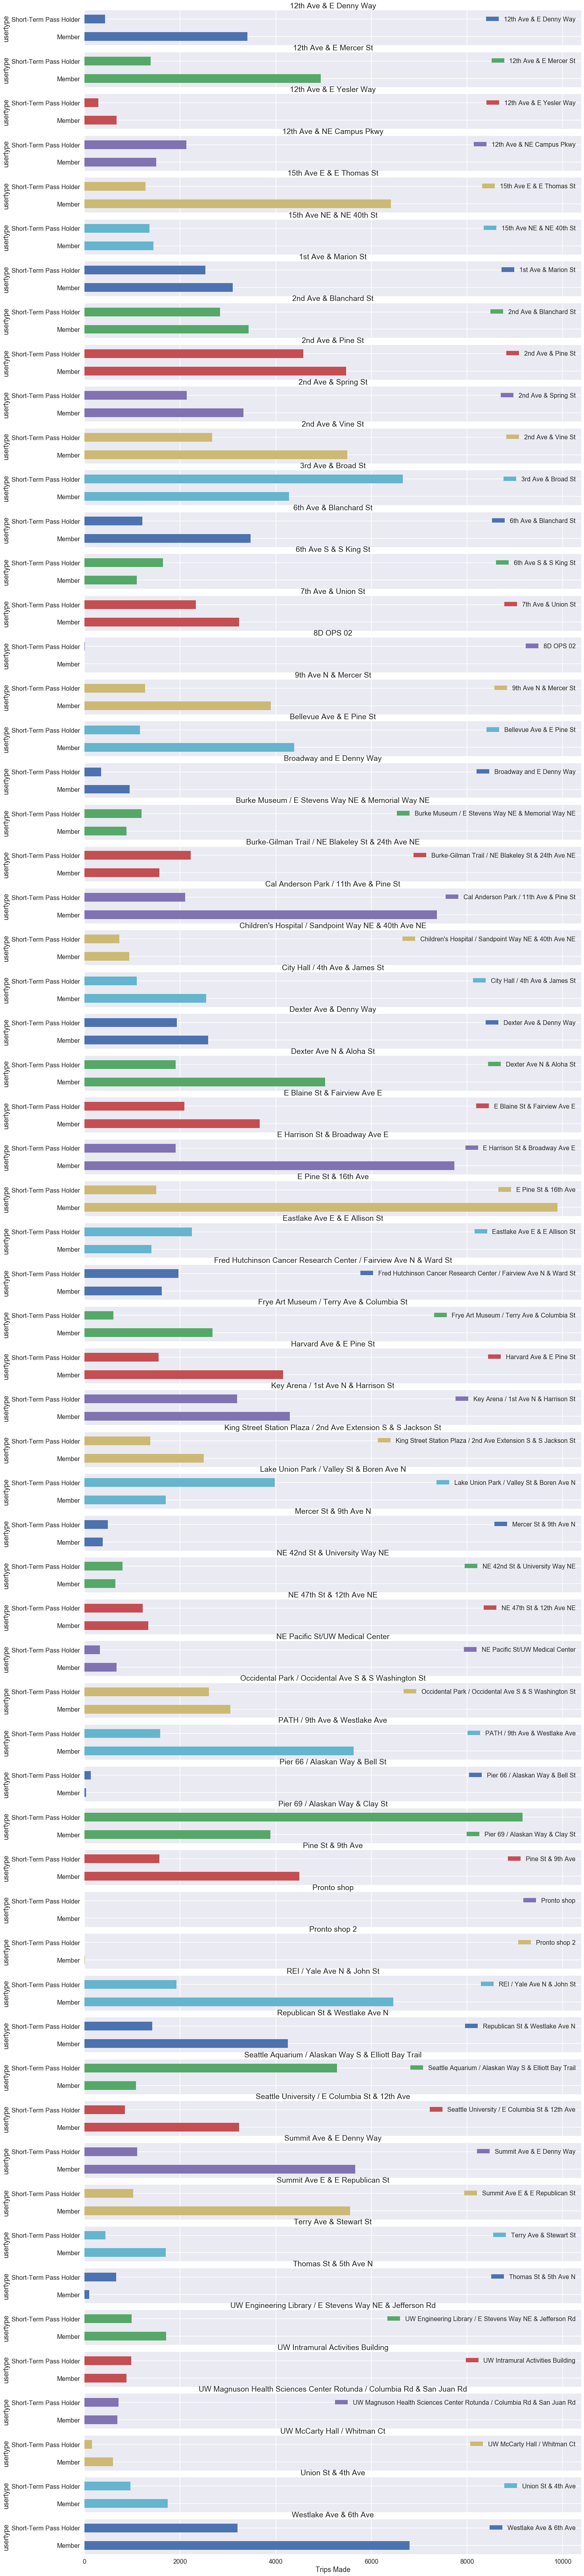

In [258]:
#Grouping the trips_data Dataframe by usertype and station to count the number of trips made by each group
from_station_usertype = trip_data[['usertype','from_station_name','trip_id']]
group_fstaion_usertype = from_station_usertype.groupby(['from_station_name','usertype'])
count_fstation_user = group_fstaion_usertype['trip_id'].count()

#Plotting the comparison on a horizintal bar graph
plt.style.use('seaborn-poster')
count_fstation_user.unstack(level=0).plot(kind='barh',subplots=True,figsize = (20,110))
plt.xlabel('Trips Made')
plt.show()

#### The top 5 most popular starting points for members and the number of member trips that originated from them

In [252]:
member_trip_data['from_station_name'].value_counts().head(5)

E Pine St & 16th Ave                      9895
E Harrison St & Broadway Ave E            7736
Cal Anderson Park / 11th Ave & Pine St    7367
Westlake Ave & 6th Ave                    6795
REI / Yale Ave N & John St                6459
Name: from_station_name, dtype: int64

#### The top 5 most popular starting points for pass holders and the number of member trips that originated from them

In [253]:
pholder_trip_data['from_station_name'].value_counts().head(5)

Pier 69 / Alaskan Way & Clay St                         9163
3rd Ave & Broad St                                      6660
Seattle Aquarium / Alaskan Way S & Elliott Bay Trail    5283
2nd Ave & Pine St                                       4574
Lake Union Park / Valley St & Boren Ave N               3981
Name: from_station_name, dtype: int64

#### Horizontal Bar Graph showing the comparison between the amount of trips made by Pass Holders and Members TO each station

This graph highlights the difference in popularity of each station between temporary pass holders and members as a cycle drop off point.

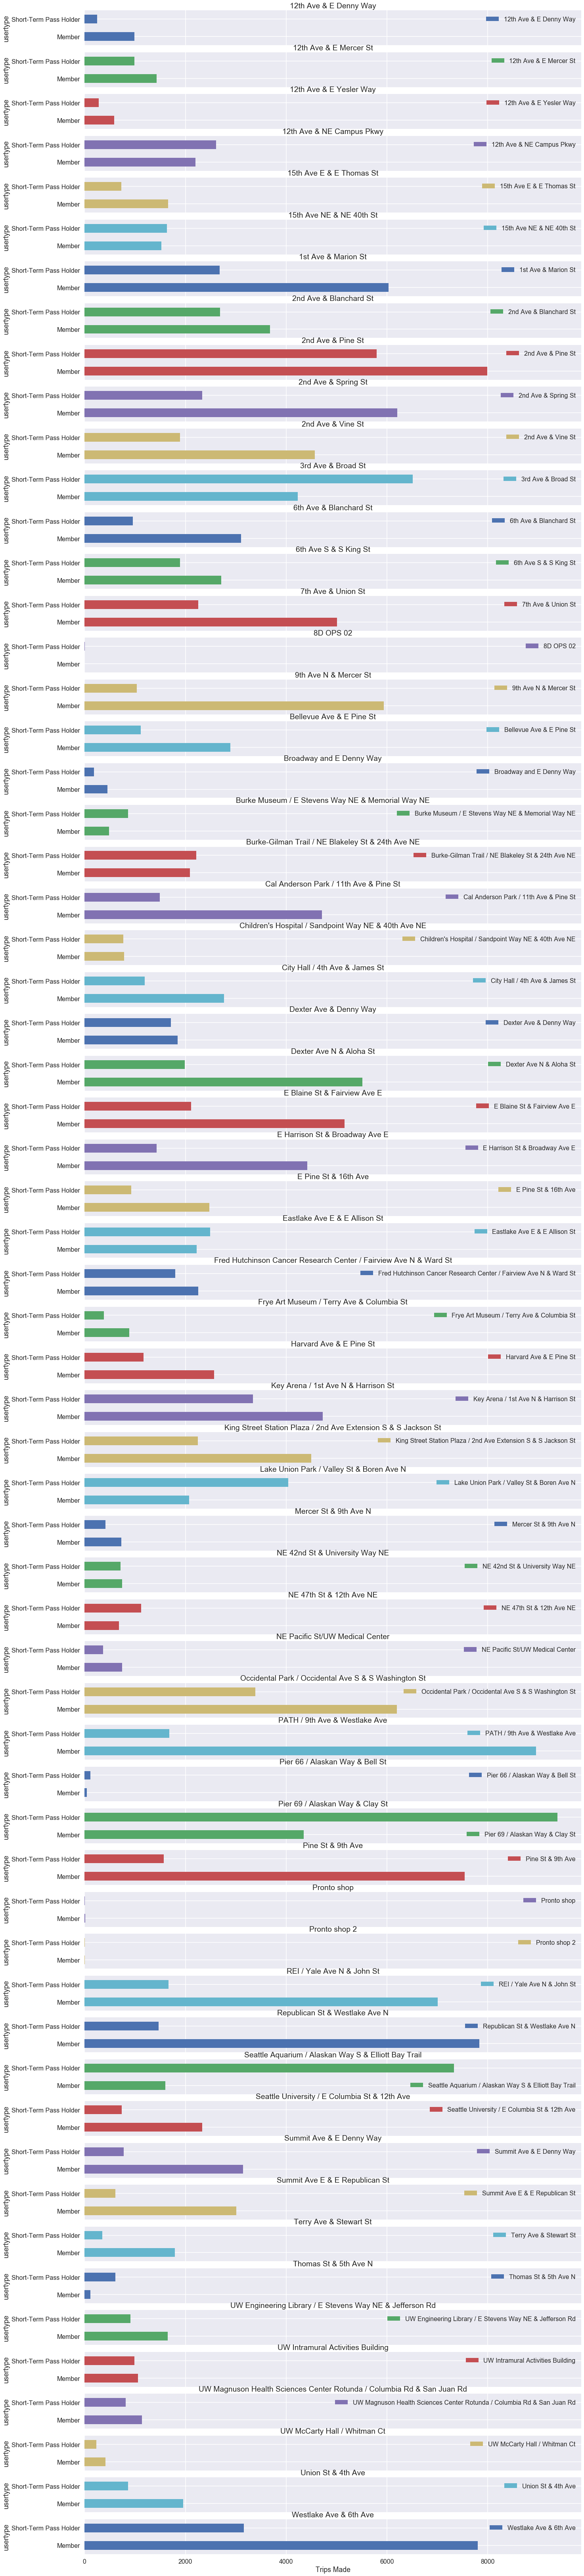

In [259]:
#Grouping the trips_data Dataframe by usertype and station to count the number of trips made by each group
to_station_usertype = trip_data[['usertype','to_station_name','trip_id']]
group_tstaion_usertype = to_station_usertype.groupby(['to_station_name','usertype'])
count_tstation_user = group_tstaion_usertype['trip_id'].count()

#Plotting the comparison on a horizintal bar graph
count_tstation_user.unstack(level=0).plot(kind='barh',subplots=True,figsize = (20,110))
plt.xlabel('Trips Made')
plt.show()

#### The top 5 most popular cycle drop off points for members and the number of trips that ended there

In [256]:
member_trip_data['to_station_name'].value_counts().head(5)

PATH / 9th Ave & Westlake Ave     8954
2nd Ave & Pine St                 7985
Republican St & Westlake Ave N    7836
Westlake Ave & 6th Ave            7804
Pine St & 9th Ave                 7541
Name: to_station_name, dtype: int64

#### The top 5 most popular cycle drop off points for members and the number of trips that ended there

In [257]:
pholder_trip_data['from_station_name'].value_counts().head(5)

Pier 69 / Alaskan Way & Clay St                         9163
3rd Ave & Broad St                                      6660
Seattle Aquarium / Alaskan Way S & Elliott Bay Trail    5283
2nd Ave & Pine St                                       4574
Lake Union Park / Valley St & Boren Ave N               3981
Name: from_station_name, dtype: int64

The most popular starting point for trips among members is 'E Pine St and 6th Avenue' while the most popular starting point among temporary passholders is 'Pier 69/Alaskan Way & Clay St'

The most popular drop off point among members is 'PATH/ 9th Avenue & Westlake Avenue' while the most popular drop off point among temporary passholders is 'Pier 69/Alaskan Way and Clay St'

The top 5 most popular stations from where trips originate or end for members are mostly different from the top 5 most popular stations for temporary passholders. The most popular stations among passholders seem to be touristy places such as Pier 69 and the Seattle Aquarium which are not as popular among users with memberships which suggests that most of the users of temporary passes for Pronto could be tourists/visitors as compared to the users of the membership which could be mostly locals.

## E.4 Correlation between the number of cycle docks at a station and it's popularity

Determining if there is a correlation between the number of bycycle docks at a station and it's popularity as a starting point or a drop off point, or lack thereof can help with resource management and answering other questions such as can the popularity of a cycle station be increased or decreased by simply adding or removing docks from it?

To answer this question, I will count the number of trips made to and from each station and merge the trip_data dataframe with the station_data dataframe to get the number of docks at each station. Then I will plot this data on seaborn lmplot to determine correlation if there is any.

In [338]:
#Grouping trips by starting point and aggregating by count
from_station = trip_data[['from_station_name','trip_id']]
from_station_group = from_station.groupby('from_station_name')
from_station_count = from_station_group['trip_id'].count()
from_station_count = pd.DataFrame(from_station_count).reset_index()
from_station_count.columns = ['name','Trips_From_Station'] 

#Grouping trips by drop off point and aggregating by count
to_station = trip_data[['to_station_name','trip_id']]
to_station_group = to_station.groupby('to_station_name')
to_station_count = to_station_group['trip_id'].count()
to_station_count = pd.DataFrame(to_station_count).reset_index()
to_station_count.columns = ['name','Trips_To_Station']

#Merging the grouped dataframes together on the names of the stations
from_to_station_count = pd.merge(from_station_count,to_station_count, on='name')

#Extracting the dockcount from the station_data dataframe
dockcount = station_data[['name','current_dockcount']]

#Merging the dockcount grouped dataframe
from_to_station_dockcount = pd.merge(from_to_station_count, dockcount, on = 'name')

#Melting the dataframe, keeping the name and dockcount columns the same to make it east to plot it on the same graph
test = pd.melt(from_to_station_dockcount, id_vars=['name','current_dockcount'])
test.columns = ['Name','Total_Docks','Direction','Trip_Count']

#Displaying the first 5 columns of the resulting dataframe to be plotted on the lmplot
test.head()

,Name,Total_Docks,Direction,Trip_Count
0,12th Ave & E Denny Way,16,Trips_From_Station,3837
1,12th Ave & E Mercer St,16,Trips_From_Station,6322
2,12th Ave & NE Campus Pkwy,16,Trips_From_Station,3630
3,15th Ave E & E Thomas St,16,Trips_From_Station,7680
4,15th Ave NE & NE 40th St,16,Trips_From_Station,2801


#### Lmplot showing the correlation between trips made to and from each station and number of docks at each station

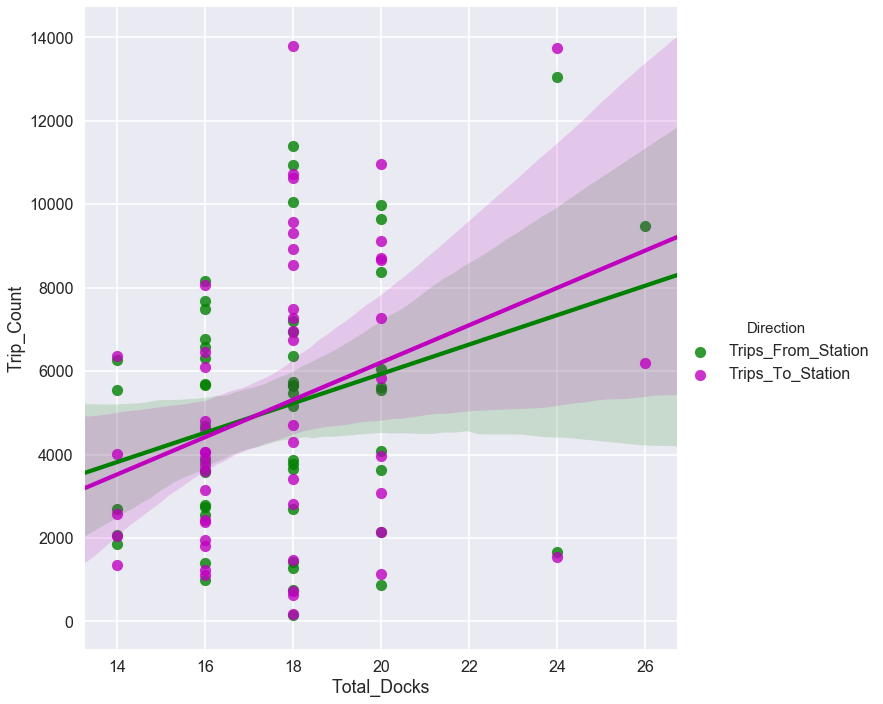

In [347]:
#Plotting the number of docks at each station on the x-axis and the number of trips to and from each station on the y-axis
#Using the hue to show the distinction between trips made to and trips made from
sns.lmplot(x='Total_Docks',y='Trip_Count',hue='Direction',palette=dict(Trips_From_Station="g", Trips_To_Station="m"),size=10, data=test)
plt.show()

This Graph shows that there is no strong correlation between the number of trips made from a station and the number of docks at the station or the number of trips made to a station and the number of docks at the station.